# Training notebook

In [1]:
from data import Div2k

In [2]:
train_hr_path = f'/home/kareka/ml/SISR/data/HR/train'
train_lr_path = f'/home/kareka/ml/SISR/data/LR_x2/bicubic/train'
val_hr_path = f'/home/kareka/ml/SISR/data/HR/validation'
val_lr_path = f'/home/kareka/ml/SISR/data/LR_x2/bicubic/valid'

train_data = Div2k(train_hr_path, train_lr_path)
valid_data = Div2k(val_hr_path, val_lr_path, subset='valid')

len(train_data), len(valid_data)

(800, 100)

In [3]:
train_data.hr_img_paths[:5]

[PosixPath('/home/kareka/ml/SISR/data/HR/train/0001.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0002.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0003.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0004.png'),
 PosixPath('/home/kareka/ml/SISR/data/HR/train/0005.png')]

In [4]:
train_data.lr_img_paths[:5]

[PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0001x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0002x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0003x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0004x4.png'),
 PosixPath('/home/kareka/ml/SISR/data/LR_x4/bicubic/train/0005x4.png')]

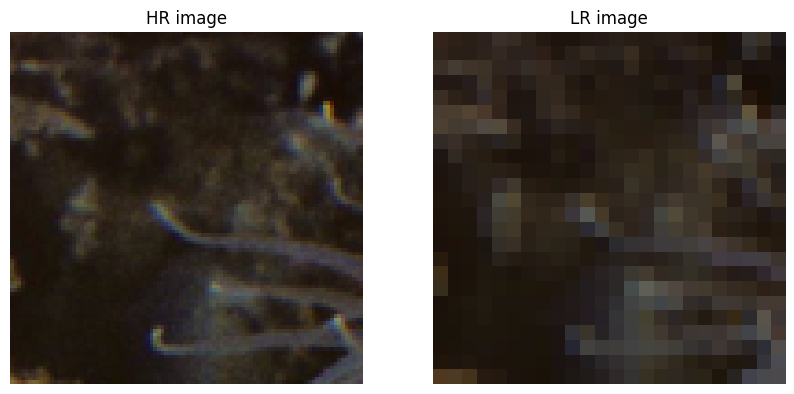

In [5]:
from utils import plot_img
import matplotlib.pyplot as plt

lr_img, hr_img = train_data[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_img(hr_img.permute(1, 2, 0), "HR image")
plt.subplot(1, 2, 2)
plot_img(lr_img.permute(1, 2, 0), "LR image")

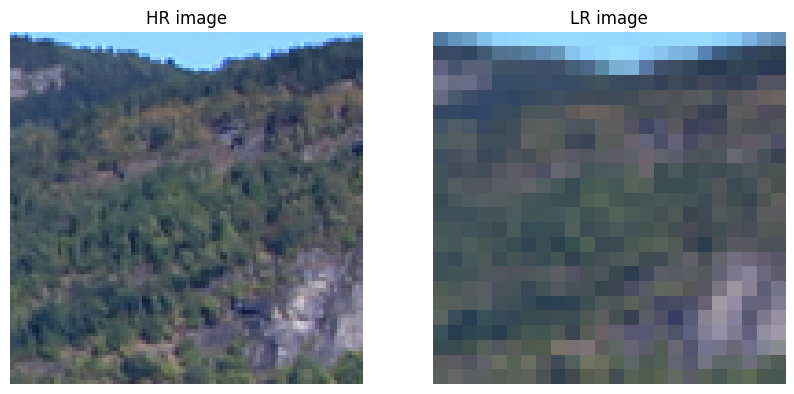

In [8]:
import random

lr_img, hr_img = valid_data[random.randint(0, len(valid_data))]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_img(hr_img.permute(1, 2, 0), "HR image")
plt.subplot(1, 2, 2)
plot_img(lr_img.permute(1, 2, 0), "LR image")

In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## DataLoaders

In [10]:
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 1

tdl = DataLoader(dataset = train_data, batch_size = TRAIN_BATCH_SIZE, shuffle = True)
vdl = DataLoader(dataset = valid_data, batch_size = VALID_BATCH_SIZE, shuffle = False)

## Model

In [11]:
from models.edsr import edsr
from torchinfo import summary

model = edsr(shape = 3, hidden_units = 64, num_res_blocks = 32, scale = 4).to(device)
summary(model = model, input_size = [TRAIN_BATCH_SIZE, 3, 24, 24])

Layer (type:depth-idx)                   Output Shape              Param #
edsr                                     [16, 3, 96, 96]           --
├─MeanShift: 1-1                         [16, 3, 24, 24]           (12)
├─Conv2d: 1-2                            [16, 64, 24, 24]          1,792
├─ModuleList: 1-3                        --                        --
│    └─edsr_res_block: 2-1               [16, 64, 24, 24]          --
│    │    └─Sequential: 3-1              [16, 64, 24, 24]          73,856
│    └─edsr_res_block: 2-2               [16, 64, 24, 24]          --
│    │    └─Sequential: 3-2              [16, 64, 24, 24]          73,856
│    └─edsr_res_block: 2-3               [16, 64, 24, 24]          --
│    │    └─Sequential: 3-3              [16, 64, 24, 24]          73,856
│    └─edsr_res_block: 2-4               [16, 64, 24, 24]          --
│    │    └─Sequential: 3-4              [16, 64, 24, 24]          73,856
│    └─edsr_res_block: 2-5               [16, 64, 24, 24]       

In [12]:
from train import train

In [13]:
EPOCHS = 100
LR = 0.0001
GAMMA = 0.8577

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)

train(model = model,
      train_dataloader = tdl,
      test_dataloader = vdl,
      epochs = EPOCHS,
      loss_fn = loss_fn,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

----------------
| Epoch 1/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0972 | Train PSNR: 18.9380 |
| Validation loss: 0.0613 | Validation PSNR: 21.5463 |
Epoch 1 took 127.95 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 2/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0551 | Train PSNR: 22.6460 |
| Validation loss: 0.0463 | Validation PSNR: 23.6491 |
Epoch 2 took 133.31 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 3/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0466 | Train PSNR: 24.1708 |
| Validation loss: 0.0431 | Validation PSNR: 24.7074 |
Epoch 3 took 133.96 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 4/100 |
----------------

---------------------------------------------------------
| Train loss: 0.0300 | Train PSNR: 29.8514 |
| Validation loss: 0.0306 | Validation PSNR: 29.0782 |
Epoch 27 took 127.47 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 28/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0311 | Train PSNR: 29.5119 |
| Validation loss: 0.0318 | Validation PSNR: 29.5480 |
Epoch 28 took 126.07 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 29/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0311 | Train PSNR: 29.4794 |
| Validation loss: 0.0314 | Validation PSNR: 29.3177 |
Epoch 29 took 125.61 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 30/100 |
----------------
-------------------------------------------

---------------------------------------------------------
| Train loss: 0.0293 | Train PSNR: 30.2881 |
| Validation loss: 0.0281 | Validation PSNR: 30.8861 |
Epoch 53 took 126.53 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 54/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0301 | Train PSNR: 29.9413 |
| Validation loss: 0.0321 | Validation PSNR: 28.7899 |
Epoch 54 took 126.67 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 55/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0293 | Train PSNR: 30.3849 |
| Validation loss: 0.0338 | Validation PSNR: 29.2635 |
Epoch 55 took 124.83 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 56/100 |
----------------
-------------------------------------------

---------------------------------------------------------
| Train loss: 0.0282 | Train PSNR: 30.6670 |
| Validation loss: 0.0265 | Validation PSNR: 30.4931 |
Epoch 79 took 126.75 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 80/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0288 | Train PSNR: 30.5364 |
| Validation loss: 0.0300 | Validation PSNR: 29.9037 |
Epoch 80 took 126.26 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 81/100 |
----------------
---------------------------------------------------------
| Train loss: 0.0289 | Train PSNR: 30.6415 |
| Validation loss: 0.0278 | Validation PSNR: 30.0332 |
Epoch 81 took 125.81 seconds to train and validate
---------------------------------------------------------

----------------
| Epoch 82/100 |
----------------
-------------------------------------------

(    Epoch  Train Loss  Train PSNR  Validation Loss  Validation PSNR  \
 0       0    0.097227   18.937963         0.061325        21.546328   
 1       1    0.055148   22.645952         0.046345        23.649115   
 2       2    0.046634   24.170818         0.043050        24.707405   
 3       3    0.044206   24.978962         0.040304        25.468916   
 4       4    0.040345   25.884912         0.040753        25.991402   
 ..    ...         ...         ...              ...              ...   
 95     95    0.028750   30.697258         0.031964        29.736116   
 96     96    0.028231   31.065554         0.028314        30.551714   
 97     97    0.028998   30.760164         0.029135        30.022789   
 98     98    0.028065   30.904137         0.027613        30.558115   
 99     99    0.029097   30.621357         0.029481        29.663515   
 
     Epoch time  
 0   127.950621  
 1   133.314601  
 2   133.964368  
 3   130.024959  
 4   128.364570  
 ..         ...  
 95  126

In [14]:
from utils import resolve_and_plot_random, compare_with_bicubic

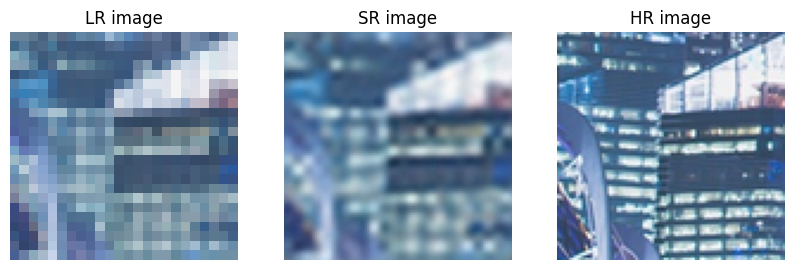

In [15]:
resolve_and_plot_random(model = model, data = valid_data, device = device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------------------
PSNR b/w SR and HR images     : 33.245819091796875
PSNR b/w Bicubic and HR images: 33.21424102783203
----------------------------------------------------------------


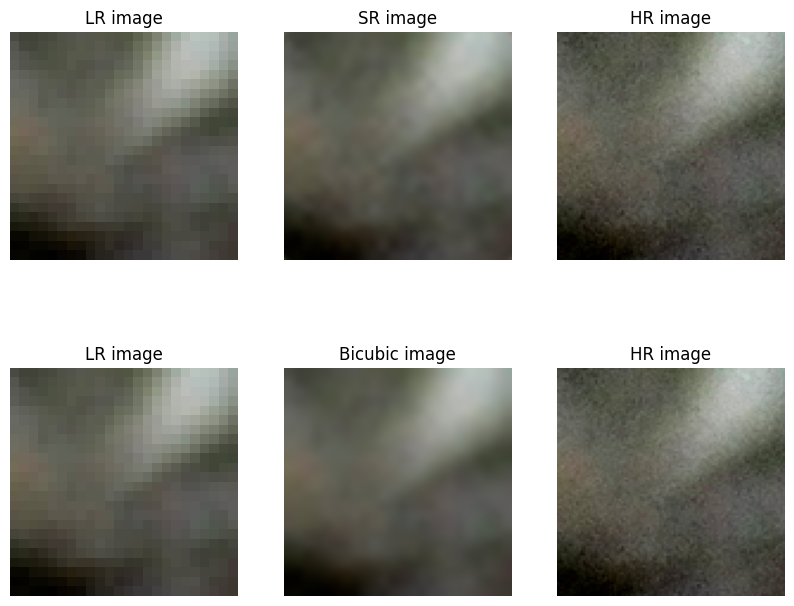

In [52]:
compare_with_bicubic(model = model, data = valid_data, scale = 4, device = device)

In [55]:
from pathlib import Path

save_path = Path('/home/kareka/ml/SISR/weights/edsr/x4/')
name = f"edsr-32-x4-L1Loss"
torch.save({
            'epoch': 100, # starts 
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': 0.0001,
            'scheduler_state_dict': scheduler.state_dict(),
            'gamma': 0.8577,
            'loss': 'L1Loss',
            }, save_path / name)

In [60]:
loaded_pkl = torch.load(save_path / name)

loaded_model = edsr(shape = 3, hidden_units = 64, num_res_blocks = 32, scale = 4)
loaded_optim = torch.optim.Adam(loaded_model.parameters(), lr = loaded_pkl['lr'])
loaded_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma = loaded_pkl['gamma'])

loaded_model.load_state_dict(loaded_pkl['model_state_dict'])
loaded_optim.load_state_dict(loaded_pkl['optimizer_state_dict'])
loaded_sched.load_state_dict(loaded_pkl['scheduler_state_dict'])

In [61]:
loaded_model = loaded_model.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------------------
PSNR b/w SR and HR images     : 30.921201705932617
PSNR b/w Bicubic and HR images: 29.922388076782227
----------------------------------------------------------------


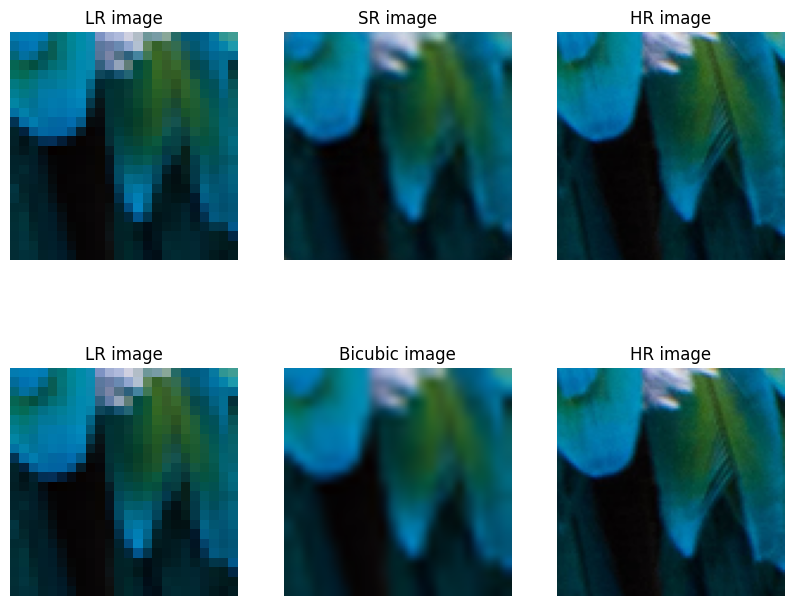

In [65]:
compare_with_bicubic(model = loaded_model, data = valid_data, scale = 4, device = device)